In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
import scipy  #Used to upsample our image

import os
import cv2
from PIL import Image
import numpy as np

In [2]:
image_directory = 'cell_images/'
SIZE = 224
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
label = []  #Placeholders to define add labels. We will add 1 to all parasitized images and 0 to uninfected.

parasitized_images = os.listdir(image_directory + 'Parasitized/')
for i, image_name in enumerate(parasitized_images):    #Remember enumerate method adds a counter and returns the enumerate object
    
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'Parasitized/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)

In [3]:
uninfected_images = os.listdir(image_directory + 'Uninfected/')
for i, image_name in enumerate(uninfected_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'Uninfected/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)

In [4]:
dataset = np.array(dataset)
label = np.array(label)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 0)

In [6]:
X_train = X_train /255.
X_test = X_test /255.

In [7]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [8]:
def get_model(input_shape = (224,224,3)):
    
    vgg = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = input_shape)

    #for layer in vgg.layers[:-8]:  #Set block4 and block5 to be trainable. 
    for layer in vgg.layers[:-5]:    #Set block5 trainable, all others as non-trainable
        print(layer.name)
        layer.trainable = False #All others as non-trainable.

    x = vgg.output
    x = GlobalAveragePooling2D()(x) #Use GlobalAveragePooling and NOT flatten. 
    x = Dense(2, activation="softmax")(x)  #We are defining this as multiclass problem. 

    model = Model(vgg.input, x)
    model.compile(loss = "categorical_crossentropy", 
                  optimizer = SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
    
    return model

In [9]:
model = get_model(input_shape = (224,224,3))
print(model.summary())

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2

C:\Users\saidh\anaconda3\envs\tensorflow\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [10]:
from keras.callbacks import ModelCheckpoint
filepath = "smodel.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [11]:
history = model.fit(X_train, y_train, batch_size=32,callbacks= callbacks_list, epochs=30, verbose = 1, 
                    validation_data=(X_test,y_test))

Epoch 1/30
15/15 [==============================] - 28s 916ms/step - loss: 0.7583 - accuracy: 0.5125 - val_loss: 0.6878 - val_accuracy: 0.5750

Epoch 00001: val_accuracy improved from -inf to 0.57500, saving model to smodel.h5
Epoch 2/30
15/15 [==============================] - 5s 352ms/step - loss: 0.7021 - accuracy: 0.4875 - val_loss: 0.6755 - val_accuracy: 0.5750

Epoch 00002: val_accuracy did not improve from 0.57500
Epoch 3/30
15/15 [==============================] - 5s 344ms/step - loss: 0.6802 - accuracy: 0.6000 - val_loss: 0.6772 - val_accuracy: 0.5833

Epoch 00003: val_accuracy improved from 0.57500 to 0.58333, saving model to smodel.h5
Epoch 4/30
15/15 [==============================] - 5s 346ms/step - loss: 0.6763 - accuracy: 0.5896 - val_loss: 0.6644 - val_accuracy: 0.7250

Epoch 00004: val_accuracy improved from 0.58333 to 0.72500, saving model to smodel.h5
Epoch 5/30
15/15 [==============================] - 6s 378ms/step - loss: 0.6690 - accuracy: 0.6250 - val_loss: 0.656

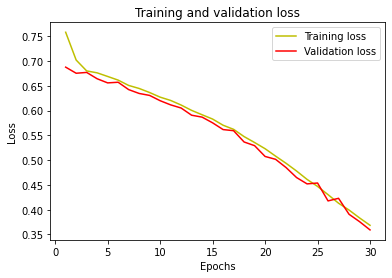

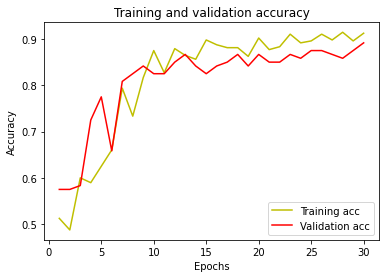

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

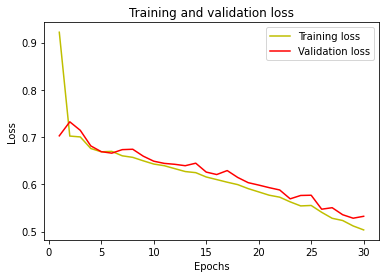

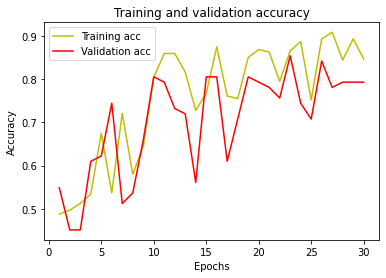

In [22]:
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# plt.plot(epochs, acc, 'y', label='Training acc')
# plt.plot(epochs, val_acc, 'r', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [23]:
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

3/3 [==============================] - 1s 213ms/step - loss: 0.5324 - accuracy: 0.7927
Accuracy =  79.2682945728302 %


The prediction for this image is:  0
The actual label for this image is:  0


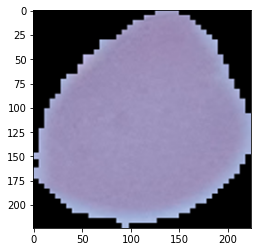

In [14]:
n=10  #Select the index of image to be loaded for testing
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", np.argmax(model.predict(input_img)))
print("The actual label for this image is: ", np.argmax(y_test[n]))


<AxesSubplot:>

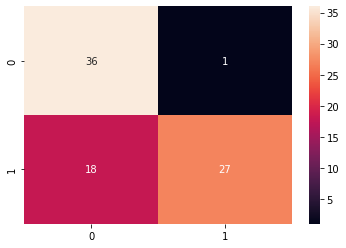

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.argmax(model.predict(X_test), axis=1)
cm=confusion_matrix(np.argmax(y_test, axis=1), y_pred)  
sns.heatmap(cm, annot=True)

<AxesSubplot:>

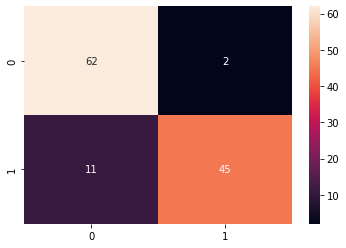

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.argmax(model.predict(X_test), axis=1)
cm=confusion_matrix(np.argmax(y_test, axis=1), y_pred)  
sns.heatmap(cm, annot=True)

In [16]:
parasited_image_idx = np.where(y_pred == 1)[0]

#Save all images classified as parasited to a directory (optional, makes sense for large data sets)
#capture it in memory as an array
predicted_as_para=[]
for i in parasited_image_idx:
    par_img = X_test[i]
    #plt.imsave("results_classified_as_para/para_"+str(i)+".png", par_img)
    predicted_as_para.append(par_img)
    
predicted_as_para = np.array(predicted_as_para)    

224 224
1
(512, 2)
[ 0.05963614  0.0357751  -0.03123024  0.0102154  -0.07021102  0.0230843
 -0.01876658 -0.07010922  0.01685635 -0.011772   -0.03126886 -0.0738164
 -0.0637876   0.06598189 -0.08587803  0.08107611  0.01984391 -0.08453371
 -0.07135645 -0.0933703   0.05438282  0.07338233  0.08267407  0.00487325
 -0.08364962 -0.08612487  0.0263934  -0.09173456 -0.04339387 -0.03206096
 -0.00843049  0.01028488  0.00270291  0.09155338 -0.06566449 -0.09534016
  0.07652443 -0.10853418 -0.04014638  0.0791837   0.02476577  0.01278009
  0.08966325 -0.07536966  0.00341834 -0.03154193  0.02401742 -0.01491632
  0.0392188  -0.04948594  0.08677634  0.09920987  0.07410369 -0.06109298
 -0.05982178 -0.11166056  0.03288942  0.10257198 -0.03996004  0.10008014
 -0.05277158 -0.0235482   0.08206696 -0.04901147  0.10638802 -0.06675619
 -0.02854156  0.07400128  0.04323099  0.03149467  0.06516848 -0.00707763
 -0.00537966  0.01955174 -0.03618632  0.00294262  0.09438423 -0.06370247
 -0.10710496 -0.06199204 -0.100193

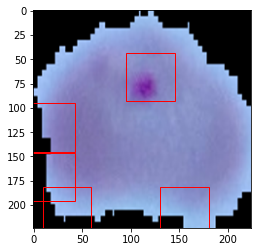

In [17]:
import scipy

parasited_image_idx = np.where(y_pred == 1)[0]

#Save all images classified as parasited to a directory (optional, makes sense for large data sets)
#capture it in memory as an array
predicted_as_para=[]
for i in parasited_image_idx:
    par_img = X_test[i]
    #plt.imsave("results_classified_as_para/para_"+str(i)+".png", par_img)
    predicted_as_para.append(par_img)
    
predicted_as_para = np.array(predicted_as_para)    

print(img.shape[0],img.shape[1])

from matplotlib.patches import Rectangle #To add a rectangle overlay to the image
from skimage.feature.peak import peak_local_max  #To detect hotspots in 2D images. 
def plot_heatmap(img):
  
    pred = model.predict(np.expand_dims(img, axis=0))
    pred_class = np.argmax(pred)
    print(pred_class)
    #Get weights for all classes from the prediction layer
    last_layer_weights = model.layers[-1].get_weights()[0] #Prediction layer
    print(last_layer_weights.shape)
    #Get weights for the predicted class.
    last_layer_weights_for_pred = last_layer_weights[:, pred_class]
    print(last_layer_weights_for_pred)
    print(last_layer_weights_for_pred.shape)
    #Get output from the last conv. layer
    last_conv_model = Model(model.input, model.get_layer("block5_conv3").output)
    last_conv_output = last_conv_model.predict(img[np.newaxis,:,:,:])
    last_conv_output = np.squeeze(last_conv_output)
    print(last_conv_output.shape)
    
    #Upsample/resize the last conv. output to same size as original image
    h = int(img.shape[0]/last_conv_output.shape[0])
    w = int(img.shape[1]/last_conv_output.shape[1])
    upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output, (h, w, 1), order=1)
    
    heat_map = np.dot(upsampled_last_conv_output.reshape((img.shape[0]*img.shape[1], 512)), 
                 last_layer_weights_for_pred).reshape(img.shape[0],img.shape[1])
    
    #Since we have a lot of dark pixels where the edges may be thought of as 
    #high anomaly, let us drop all heat map values in this region to 0.
    #This is an optional step based on the image. 
    heat_map[img[:,:,0] == 0] = 0  #All dark pixels outside the object set to 0
    
    #Detect peaks (hot spots) in the heat map. We will set it to detect maximum 5 peaks.
    #with rel threshold of 0.5 (compared to the max peak). 
    peak_coords = peak_local_max(heat_map, num_peaks=5, threshold_rel=0.5, min_distance=10) 

    plt.imshow(img.astype('float32').reshape(img.shape[0],img.shape[1],3))
    plt.imshow(heat_map, cmap='jet', alpha=0.30)
    for i in range(0,peak_coords.shape[0]):
        print(i)
        y = peak_coords[i,0]
        x = peak_coords[i,1]
        plt.gca().add_patch(Rectangle((x-25, y-25), 50,50,linewidth=1,edgecolor='r',facecolor='none'))

    

import random 
im = random.randint(0,predicted_as_para.shape[0]-1)
heat_map =plot_heatmap(predicted_as_para[im])

img = predicted_as_para[im]
plt.imshow(predicted_as_para[im])

0


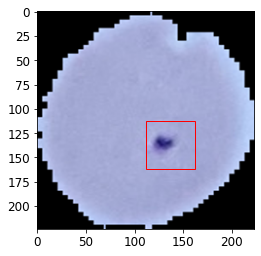

In [36]:
import random 
im = random.randint(0,predicted_as_para.shape[0]-1)
heat_map =plot_heatmap(predicted_as_para[im])

img = predicted_as_para[im]
plt.imshow(predicted_as_para[im])

1
(512, 2)
[ 5.55811413e-02  4.65616435e-02  8.82602409e-02 -7.10275164e-03
 -4.80602123e-02 -3.76368426e-02  2.37784591e-02 -1.99904852e-03
  4.33697961e-02  2.92224102e-02  1.02359399e-01  4.91498820e-02
  7.77252614e-02 -4.16479073e-02 -2.40456630e-02  2.49510910e-02
  4.25608344e-02 -1.80871859e-02 -5.67151904e-02  8.66478309e-02
 -2.34189630e-02 -7.25463703e-02 -6.27651811e-02 -5.94905205e-03
 -1.07366130e-01 -8.84201378e-03  9.62632149e-03 -1.02066115e-01
  4.21667658e-02 -8.91344249e-02 -3.73744741e-02 -7.14003667e-02
 -6.17113039e-02 -1.79455429e-03 -1.75848417e-02 -7.24228770e-02
  1.05729498e-01  2.97860317e-02 -3.48884612e-02  2.93149060e-04
  2.14536916e-02 -5.57180420e-02 -7.85404444e-02  6.74150186e-03
 -2.05583908e-02  1.05812795e-01  2.07458921e-02 -2.47145016e-02
  8.73243958e-02 -3.17188948e-02  7.92985484e-02  2.99589918e-03
  8.56352225e-02  5.10956459e-02 -8.55602920e-02  5.09181572e-03
  1.54318120e-02  6.30630553e-02  8.56220908e-03 -1.00783974e-01
 -9.50103477e-

0


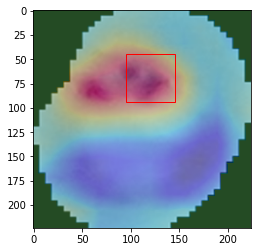

In [15]:
import scipy

parasited_image_idx = np.where(y_pred == 1)[0]

#Save all images classified as parasited to a directory (optional, makes sense for large data sets)
#capture it in memory as an array
predicted_as_para=[]
for i in parasited_image_idx:
    par_img = X_test[i]
    #plt.imsave("results_classified_as_para/para_"+str(i)+".png", par_img)
    predicted_as_para.append(par_img)
    
predicted_as_para = np.array(predicted_as_para)    

# print(img.shape[0],img.shape[1])

from matplotlib.patches import Rectangle #To add a rectangle overlay to the image
from skimage.feature.peak import peak_local_max  #To detect hotspots in 2D images. 
def plot_heatmap(img):
  
    pred = model.predict(np.expand_dims(img, axis=0))
    pred_class = np.argmax(pred)
    print(pred_class)
    #Get weights for all classes from the prediction layer
    last_layer_weights = model.layers[-1].get_weights()[0] #Prediction layer
    print(last_layer_weights.shape)
    #Get weights for the predicted class.
    last_layer_weights_for_pred = last_layer_weights[:, pred_class]
    print(last_layer_weights_for_pred)
    print(last_layer_weights_for_pred.shape)
    #Get output from the last conv. layer
    last_conv_model = Model(model.input, model.get_layer("block5_conv3").output)
    last_conv_output = last_conv_model.predict(img[np.newaxis,:,:,:])
    last_conv_output = np.squeeze(last_conv_output)
    print(last_conv_output.shape)
    
    #Upsample/resize the last conv. output to same size as original image
    h = int(img.shape[0]/last_conv_output.shape[0])
    w = int(img.shape[1]/last_conv_output.shape[1])
    upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output, (h, w, 1), order=1)
    
    heat_map = np.dot(upsampled_last_conv_output.reshape((img.shape[0]*img.shape[1], 512)), 
                 last_layer_weights_for_pred).reshape(img.shape[0],img.shape[1])
    
    #Since we have a lot of dark pixels where the edges may be thought of as 
    #high anomaly, let us drop all heat map values in this region to 0.
    #This is an optional step based on the image. 
    heat_map[img[:,:,0] == 0] = 0  #All dark pixels outside the object set to 0
    
    #Detect peaks (hot spots) in the heat map. We will set it to detect maximum 5 peaks.
    #with rel threshold of 0.5 (compared to the max peak). 
    peak_coords = peak_local_max(heat_map, num_peaks=5, threshold_rel=0.5, min_distance=10) 

    plt.imshow(img.astype('float32').reshape(img.shape[0],img.shape[1],3))
    plt.imshow(heat_map, cmap='jet', alpha=0.30)
    for i in range(0,peak_coords.shape[0]):
        print(i)
        y = peak_coords[i,0]
        x = peak_coords[i,1]
        plt.gca().add_patch(Rectangle((x-25, y-25), 50,50,linewidth=1,edgecolor='r',facecolor='none'))

    

import random 
im = random.randint(0,predicted_as_para.shape[0]-1)
heat_map =plot_heatmap(predicted_as_para[im])

# img = predicted_as_para[im]
# plt.imshow(predicted_as_para[im])

In [1]:
im

NameError: name 'im' is not defined